In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy.stats import ttest_ind
import nltk
nltk.download([
    "stopwords" ])
from nltk.probability import FreqDist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Defining functions

In [2]:
# Define function that checks for the use of specific words, now case-insensitive
def contains_any(string, words):
    # Normalize the case of the input string
    string_lower = string.lower()
    # Return 1 if any word is found, otherwise 0
    return int(any(word in string_lower for word in words))

In [3]:
# Define the function that counts words in a sentence
def count_words(sentence):
    # Split the sentence into words based on whitespace
    words = sentence.split()
    # Return the number of words
    return len(words)

In [4]:
# Function to fit model and extract parameters
def fit_ols(x, y):
    x = sm.add_constant(x)  # adding a constant
    model = sm.OLS(y, x).fit()
    return model.params[1], model.params[0], model.pvalues[1]  # slope, intercept, p-value of slope

# Organizing Database
### Loading Data with the Sentimental Analysis classification

In [5]:
# loading the data
df_1 = pd.read_csv('data_final.csv')

# Getting rid of the id column
df_1 = df_1.iloc[:, 2:]

# Getting rid of comments column
df_1 = df_1.drop("Unnamed: 18", axis = 1)

### period: combination of day, month and year

In [6]:
df_1["count"] = "-"
df_1["period"] = df_1["year"].astype(str) + df_1["count"] + df_1["month"].astype(str) + df_1["count"] + df_1["day"].astype(str)
df_1 = df_1.drop("count", axis = 1)
df_1["period"] = pd.to_datetime(df_1['period'])

### association: defining wether the party is associated with the Governmenternment, the Oppositionosition, inependent, or have a Peace position

In [7]:
df_2 = pd.read_excel(r"parties.xlsx")
df = df_1.merge(df_2, how='left', on='party')

### n_tweet: number of tweets per person

In [8]:
# count occurrences a particular column
df_3 = df.groupby(['author']).size()
 
# Convert the series to a DataFrame
df_3 = df_3.reset_index(name='n_tweet')

# Merging with the main dataframe
df = df.merge(df_3, how='left', on='author')

### avg_score: Average score per Congressperson

In [9]:
# Group by 'author', 'association', and 'party' and calculate the mean of 'score', name the new column 'avg_score'
df_4 = df.groupby(['author'], as_index=False)['score'].mean().rename(columns={'score': 'avg_score'})

# Merging with the main dataframe
df = df.merge(df_4, how='left', on='author')

### avg_likes: average number of likes per congressperson

In [10]:
# Group by 'author', 'association', and 'party' and calculate the mean of 'score', name the new column 'avg_score'
df_4 = df.groupby(['author'], as_index=False)['likes'].mean().rename(columns={'likes': 'avg_likes'})

# Merging with the main dataframe
df = df.merge(df_4, how='left', on='author')

### length: number of words per tweet

In [11]:
df_5 = df[["tweet"]].copy()  # Use copy() to avoid SettingWithCopyWarning

# Calculate the word count for each tweet using the count_words function
df_5["length"] = df_5["tweet"].apply(count_words)

# Merge on index
df = df.merge(df_5["length"], left_index=True, right_index=True)

## Computing presence of figure heads

In [12]:
df_6 = df[["tweet"]].copy()  # Use copy() to avoid SettingWithCopyWarning

# Last name of current president
petro = ["petro"]

# Calculate the presence of any president-related words and convert to integer
df_6["petro"] = df_6["tweet"].apply(lambda x: contains_any(x, petro))

# Merge on index
df = df.merge(df_6["petro"], left_index=True, right_index=True)

In [13]:
df_7 = df[["tweet"]].copy()  # Use copy() to avoid SettingWithCopyWarning

# Last name of current president
uribe = ["uribe"]

# Calculate the presence of any president-related words and convert to integer
df_7["uribe"] = df_7["tweet"].apply(lambda x: contains_any(x, uribe))

# Merge on index
df = df.merge(df_7["uribe"], left_index=True, right_index=True)

In [14]:
df_8 = df[["tweet"]].copy()  # Use copy() to avoid SettingWithCopyWarning

# Last name of current president
duque = ["duque"]

# Calculate the presence of any president-related words and convert to integer
df_8["duque"] = df_8["tweet"].apply(lambda x: contains_any(x, duque))

# Merge on index
df = df.merge(df_8["duque"], left_index=True, right_index=True)

In [15]:
df_9 = df[["tweet"]].copy()  # Use copy() to avoid SettingWithCopyWarning

# Last name of current president
santos = ["santos"]

# Calculate the presence of any president-related words and convert to integer
df_9["santos"] = df_9["tweet"].apply(lambda x: contains_any(x, santos))

# Merge on index
df = df.merge(df_9["santos"], left_index=True, right_index=True)

## Usage of multimedia 

In [16]:
multi = list(df[(df["photo_face"] == 1)  |( df["photo_other"] == 1 )| (df["photo_invitation"] == 1) | (df["video_face"] == 1)| (df["video_other"] == 1)].index)
multi_info = list(df[(df["photo_informative"] == 1)|(df["news"] == 1 )].index)

df["multi"] = 0

for i in multi:
    df["multi"].iloc[i] = 1
    
for i in multi_info:
    df["multi"].iloc[i] = 2

C:\Users\maria\AppData\Local\Temp\ipykernel_10072\1689280249.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["multi"].iloc[i] = 1
C:\Users\maria\AppData\Local\Temp\ipykernel_10072\1689280249.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["multi"].iloc[i] = 2


# Cleaning data

### Generating an alternative df where variables with a score of exactly 0 are eliminated

In [17]:
# Eliminating Observations where score == 0
df_score = df[df["score"] != 0].reset_index(drop = True)
len(df_score)

17850

### Dealing with outliers within the length variable

In [18]:
df[["length"]].describe()

,length
count,21441.000000
mean,29.729257
std,13.687884
min,1.000000
25%,20.000000
50%,33.000000
75%,41.000000
max,378.000000


In [19]:
# checking wether there is any tweet with more than 200 words, and if so, droping it
more = list(df[df["length"] > 200].index)
df["tweet"].iloc[more]

4760    ,idores\nSantiago Saavedra, Daniel Mauricio Ro...
Name: tweet, dtype: object

As this tweet is not only an outlier in terms of the distribution, but also seems to have nonsensical text, it is eliminated from the database.

In [20]:
for i in more:
    df = df.drop(df.index[i])
df.reset_index(inplace = True, drop = True)    

# Basic Facts

## Participation within sample

In [21]:
total_tweets = len(df)
members = df["author"].nunique()
length = np.round(df["length"].mean(), 2)
tweets_per_member = np.round(total_tweets/members, 2)
print("total_tweets, members, avg_length, tweets_per_member")
print(total_tweets, members, length, tweets_per_member)

total_tweets, members, avg_length, tweets_per_member
21440 114 29.71 188.07


In [22]:
# Group by 'association' only once and perform all needed aggregations directly
data_party = df.groupby('association', as_index=False).agg(
    total_tweets=('score', 'count'),  # Total number of scores per association
    members=('author', 'nunique'),
    avg_length = ("length", "mean")# Count of unique authors per association
)

data_party["tweets_per_member"] = np.round(data_party["total_tweets"]/data_party["members"], 2)
data_party["avg_length"] = np.round(data_party["avg_length"], 2)
data_party

,association,total_tweets,members,avg_length,tweets_per_member
0,Government,15234,78,30.96,195.31
1,Independent,1981,12,24.19,165.08
2,Opposition,3557,14,26.77,254.07
3,Peace,480,9,32.41,53.33


In [23]:
# Group by 'gender' only once and perform all needed aggregations directly
data_gender = df.groupby('gender', as_index=False).agg(
    total_tweets=('score', 'count'),  # Total number of scores per gender
    members=('author', 'nunique'),
    avg_length = ("length", "mean")# Count of unique authors per gender
)

data_gender["tweets_per_member"] = np.round(data_gender["total_tweets"]/data_gender["members"], 2)
data_gender["avg_length"] = np.round(data_gender["avg_length"], 2)
data_gender

,gender,total_tweets,members,avg_length,tweets_per_member
0,0,15557,84,29.48,185.2
1,1,5883,30,30.33,196.1


## Gender Proportions

In [24]:
# Calculate the count of each gender within each association
gender_counts = df.groupby(['association', 'gender']).size().unstack(fill_value=0)

# Calculate proportions
gender_proportions = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# Calculate the overall proportion of each gender in the entire DataFrame
overall_gender_count = df['gender'].value_counts()
overall_gender_proportion = overall_gender_count / overall_gender_count.sum()

# Convert overall proportions to a DataFrame and transpose it for compatibility
# Rename the index to 'General' for the overall proportion
overall_proportion_df = pd.DataFrame([overall_gender_proportion], index=['General'])

# Append this to the existing gender_proportions DataFrame
complete_proportions = pd.concat([gender_proportions, overall_proportion_df])

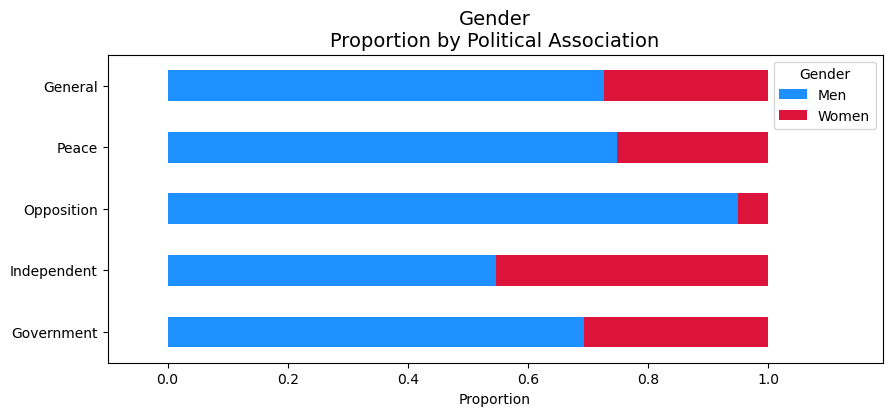

In [25]:
ax = complete_proportions.plot(kind='barh', stacked=True, color=['dodgerblue', 'crimson'], figsize=(10, 4))

plt.title('Gender\nProportion by Political Association', fontsize=14)
plt.xlabel('Proportion')
plt.legend(['Men', 'Women'], title='Gender')  # Manually setting legend labels
plt.xlim(-0.1, 1.19)  # Adjust x-limits to show full range

plt.show()

## Use of Multimedia

In [26]:
df["multi"].unique()

array([0, 2, 1], dtype=int64)

In [27]:
# Calculate the count of each multi within each association
multi_counts = df.groupby(['association', 'multi']).size().unstack(fill_value=0)

# Calculate proportions
multi_proportions = multi_counts.div(multi_counts.sum(axis=1), axis=0)

# Calculate the overall proportion of each multi in the entire DataFrame
overall_multi_count = df['multi'].value_counts()
overall_multi_proportion = overall_multi_count / overall_multi_count.sum()

# Convert overall proportions to a DataFrame and transpose it for compatibility
# Rename the index to 'General' for the overall proportion
overall_proportion_df = pd.DataFrame([overall_multi_proportion], index=['General'])

# Append this to the existing multi_proportions DataFrame
complete_proportions = pd.concat([multi_proportions, overall_proportion_df])

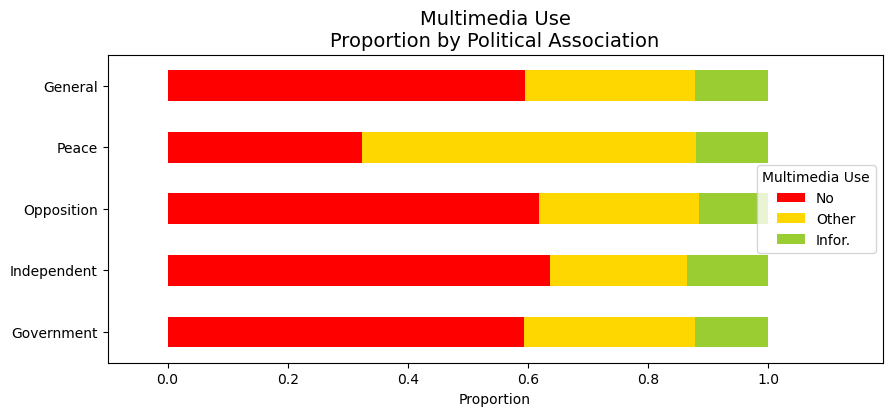

In [28]:
ax = complete_proportions.plot(kind='barh', stacked=True, color=['red', "gold", 'yellowgreen'], figsize=(10, 4))

plt.title('Multimedia Use\nProportion by Political Association', fontsize=14)
plt.xlabel('Proportion')
plt.legend(['No', 'Other', "Infor."], title='Multimedia Use')  # Manually setting legend labels
plt.xlim(-0.1, 1.19)  # Adjust x-limits to show full range

plt.show()

# Behavior: Negative and Positive Speech

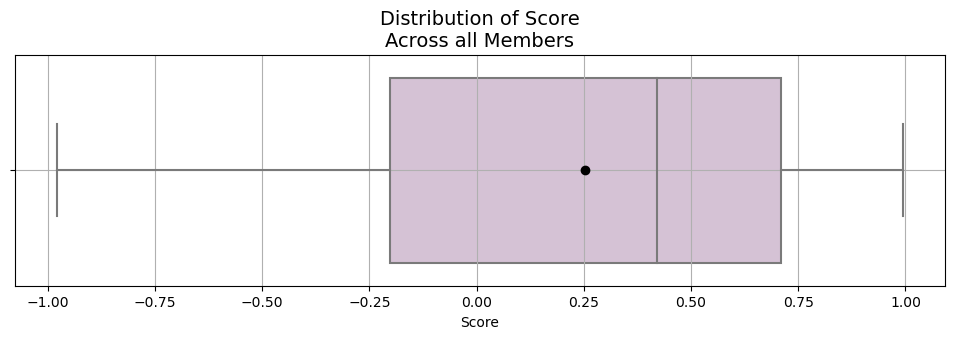

In [29]:
## Generating a plot for the distribution of likes after eliminating extreme values
# Setting the size of the plot
plt.figure(figsize=(12, 3)) 

# Plotting the boxplot
sns.boxplot(x='score', data=df_score, color="thistle")

# Highlight the mean with a black dot
plt.plot(np.mean(df_score['score']), 0, 'ko')

# Setting the titles for the boxplot
plt.title('Distribution of Score\nAcross all Members', fontsize=14)
plt.xlabel('Score')

# Enable grid
plt.grid(True)

# Plotting the graph
plt.show()

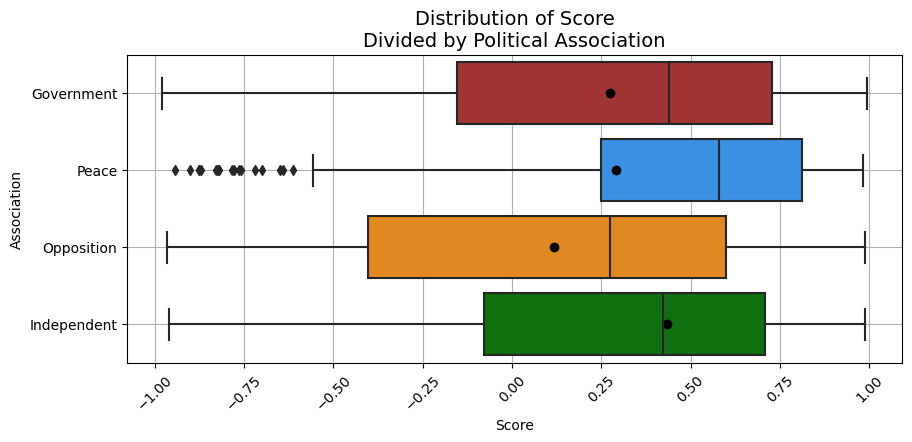

In [30]:
# Adjust the size as needed
plt.figure(figsize=(10, 4))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent" : "green"}

# Use the correct DataFrame and columns for the boxplot
ax = sns.boxplot(x='score', y='association', data=df_score, palette=palette)

# Calculate means for each group and plot them
mean_scores = df_score.groupby('association')['score'].mean()

# Plot mean points directly using gender labels mapped to y-axis positions
for gender, mean_score in mean_scores.items():
    plt.plot(mean_score, gender, 'ko')  # 'ko' creates a black dot, gender directly maps to y position

# Set the title and labels of the boxplot
# Set plot title and labels
plt.title('Distribution of Score\nDivided by Political Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')

# Rotates the labels on the x-axis for better readability
plt.xticks(rotation=45)

# Enable grid for better readability of the plot
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements

# Show the plot
plt.show()

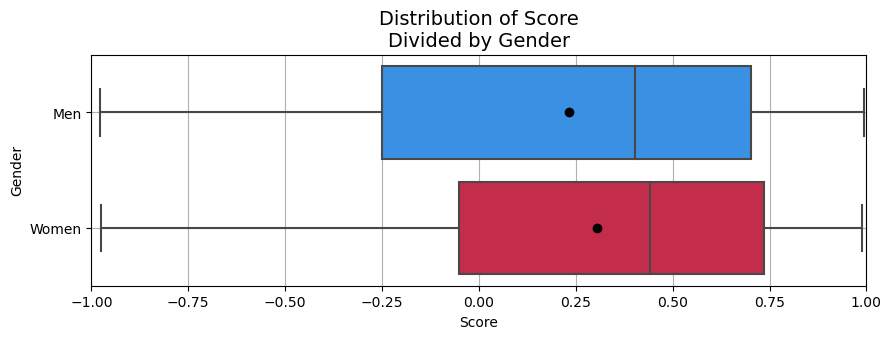

In [31]:
# Create the figure and define the color palette
plt.figure(figsize=(10, 3))
palette = {0: "dodgerblue", 1: "crimson"}  # 0: Men, 1: Women

# Create a horizontal boxplot
ax = sns.boxplot(x='score', y='gender', data=df_score, palette=palette, orient='h')

# Calculate means for each group and plot them
mean_scores = df_score.groupby('gender')['score'].mean()

# Plot mean points directly using gender labels mapped to y-axis positions
for gender, mean_score in mean_scores.items():
    plt.plot(mean_score, gender, 'ko')  # 'ko' creates a black dot, gender directly maps to y position

# Set plot title and labels
plt.title('Distribution of Score\nDivided by Gender', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Gender')

# Specify all labels on the y-axis
ax.set_yticklabels(['Men', 'Women'])

# Set the limits for the x-axis
plt.xlim(-1, 1)

# Enable and set grid below other plot elements
plt.grid(True)
ax.set_axisbelow(True)

# Display the plot
plt.show()

### Most used words by emotions

In [32]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords.append("gustavobolivar")
stopwords.append("")
stopwords.append("hoy")
stopwords.append("gran")
stopwords.append("dia")
stopwords.append("año")
stopwords.append("día")
stopwords.append("años")
stopwords.append("mejor")
stopwords.append("hace")
stopwords.append("saludos")
stopwords.append("gracias")
stopwords.append("si")
stopwords.append("no")
stopwords.append("muchas")
stopwords.append("así")
stopwords.append("personas")
stopwords.append("señora")
stopwords.append("ser")
stopwords.append("abrazo")
stopwords.append("siempre")
stopwords.append("hacer")
stopwords.append("solo")
stopwords.append("usted")
stopwords.append("feliz")
stopwords.append("total")
stopwords.append("social")
stopwords.append("nuevo")
stopwords.append("felicitaciones")

In [33]:
extreme = df.copy()
extreme["ab_score"] = abs(extreme["score"])
extreme = extreme.sort_values("ab_score").reset_index()
extreme = extreme.iloc[-int(len(df)*0.1):]
list_extreme = extreme["tweet"].tolist()

# Split each phrase into words_e and flatten the list
words_e = [word.lower() for phrase in list_extreme for word in phrase.split()]
words_e = [word.replace('.', '') for word in words_e]
words_e = [word.replace(',', '') for word in words_e]

In [34]:
filtered_words_e = [word for word in words_e if word not in stopwords]

# Create a frequency distribution
freq_dist_e = FreqDist(filtered_words_e)

# Convert frequency distribution to a DataFrame
extreme_df = pd.DataFrame(freq_dist_e.items(), columns=['Word', 'Frequency'])
extreme_df = extreme_df.sort_values("Frequency", ascending = False)

extreme_df[:15]

,Word,Frequency
68,paz,589
133,colombia,275
371,país,264
17,acuerdo,220
235,vida,201
79,gobierno,194
1,@petrogustavo,180
0,presidente,138
27,@camaracolombia,135
234,compromiso,129


# Behavior: Figures

In [35]:
# List of columns to aggregate over
columns_to_check = ['petro', 'uribe', 'duque', 'santos']

# Initialize an empty list to store results
results = []

# Loop through each column and perform the aggregation
for col in columns_to_check:
    temp = df_score[df_score[col] == 1].groupby('association', as_index=False).agg(
        avg_score=("score", 'mean'),  # Calculate the mean score for the current column
        n_tweet=('author', 'count')  # Count unique authors contributing to the scores
    )
    # Add a column to denote the column the statistics are derived from
    temp['condition'] = col
    results.append(temp)

# Concatenate all results into a single DataFrame
final_result = pd.concat(results, ignore_index=True)

# final_result = final_result[(final_result["association"] == "Government") | (final_result["association"] == "Opposition")]
final_result[["association", "condition", "avg_score", "n_tweet"]]

,association,condition,avg_score,n_tweet
0,Government,petro,0.343575,1055
1,Independent,petro,0.226265,48
2,Opposition,petro,-0.039723,448
3,Peace,petro,0.582078,32
4,Government,uribe,0.115144,84
5,Independent,uribe,-0.102700,1
6,Opposition,uribe,0.260466,62
7,Peace,uribe,-0.557400,1
8,Government,duque,-0.009181,375
9,Independent,duque,0.402460,5


In [36]:
figures = df_score[(df_score["petro"] == 1)|(df_score["uribe"] == 1)|(df_score["duque"] == 1)|(df_score["santos"] == 1)]

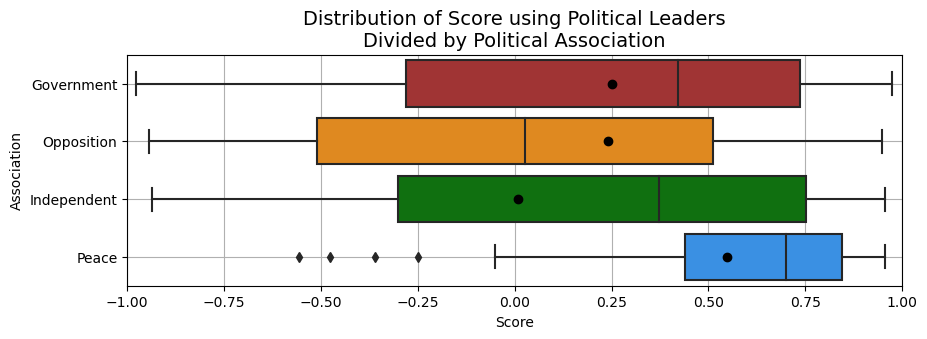

In [37]:
plt.figure(figsize=(10, 3))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent" : "green"}

# Create a horizontal boxplot with specific colors
ax = sns.boxplot(x='score', y='association', data=figures, palette=palette)

# Set plot title and labels
plt.title('Distribution of Score using Political Leaders\nDivided by Political Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')
plt.xlim(-1, 1)

# Calculate means for each group and plot them
mean_scores = figures.groupby('association')['score'].mean()

# Plot mean points directly using gender labels mapped to y-axis positions
for gender, mean_score in mean_scores.items():
    plt.plot(mean_score, gender, 'ko')  # 'ko' creates a black dot, gender directly maps to y position

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements
plt.show()

In [38]:
figures = figures[(figures["association"] == "Opposition")|(figures["association"] == "Government")].reset_index(drop = True)

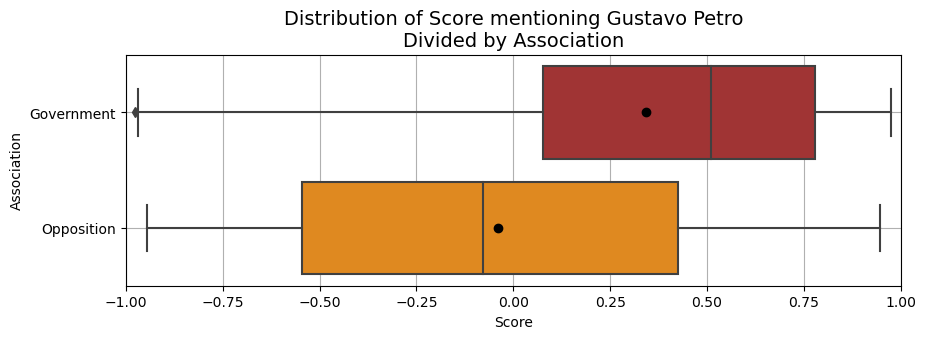

In [39]:
plt.figure(figsize=(10, 3))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent" : "green"}

# Create a horizontal boxplot with specific colors
ax = sns.boxplot(x='score', y='association', data=figures[figures["petro"] == 1], palette=palette)

# Set plot title and labels
plt.title('Distribution of Score mentioning Gustavo Petro\nDivided by Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')
plt.xlim(-1, 1)

# Calculate means for each group and plot them
mean_scores = figures[figures["petro"] == 1].groupby('association')['score'].mean()

# Plot mean points directly using association labels mapped to y-axis positions
association_order = ["Government", "Opposition"]
for association in association_order:
    mean_score = mean_scores[association]
    y_position = association_order.index(association)
    plt.plot(mean_score, y_position, 'ko')  # 'ko' creates a black dot

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements
plt.show()

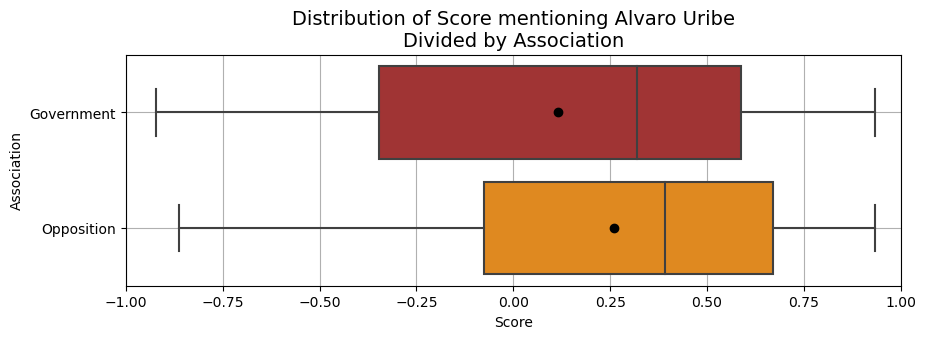

In [40]:
plt.figure(figsize=(10, 3))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent" : "green"}

# Create a horizontal boxplot with specific colors
ax = sns.boxplot(x='score', y='association', data=figures[figures["uribe"] == 1], palette=palette)

# Set plot title and labels
plt.title('Distribution of Score mentioning Alvaro Uribe\nDivided by Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')
plt.xlim(-1, 1)

# Calculate means for each group and plot them
mean_scores = figures[figures["uribe"] == 1].groupby('association')['score'].mean()

# Plot mean points directly using association labels mapped to y-axis positions
association_order = ["Government", "Opposition"]
for association in association_order:
    mean_score = mean_scores[association]
    y_position = association_order.index(association)
    plt.plot(mean_score, y_position, 'ko')  # 'ko' creates a black dot

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements
plt.show()

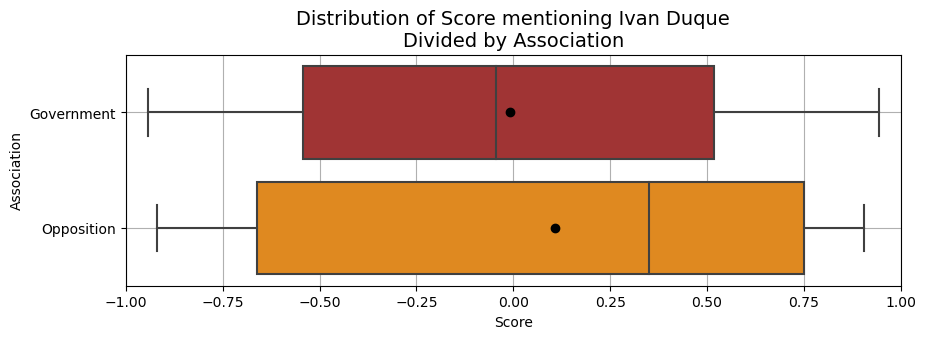

In [41]:
plt.figure(figsize=(10, 3))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent" : "green"}

# Create a horizontal boxplot with specific colors
ax = sns.boxplot(x='score', y='association', data=figures[figures["duque"] == 1], palette=palette)

# Set plot title and labels
plt.title('Distribution of Score mentioning Ivan Duque\nDivided by Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')
plt.xlim(-1, 1)

# Calculate means for each group and plot them
mean_scores = figures[figures["duque"] == 1].groupby('association')['score'].mean()

# Plot mean points directly using association labels mapped to y-axis positions
association_order = ["Government", "Opposition"]
for association in association_order:
    mean_score = mean_scores[association]
    y_position = association_order.index(association)
    plt.plot(mean_score, y_position, 'ko')  # 'ko' creates a black dot

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements
plt.show()

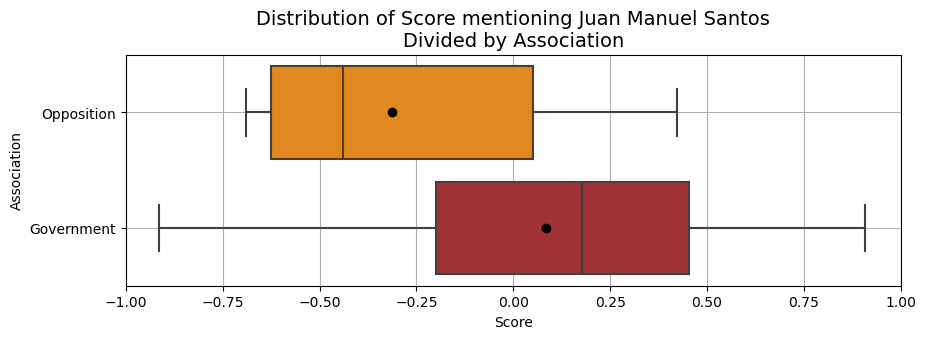

In [42]:
plt.figure(figsize=(10, 3))

# Define a color palette
palette = {'Opposition': 'darkorange', 'Government': 'firebrick'}

# Create a horizontal boxplot with specific colors
ax = sns.boxplot(x='score', y='association', data=figures[figures["santos"] == 1], palette=palette)

# Set plot title and labels
plt.title('Distribution of Score mentioning Juan Manuel Santos\nDivided by Association', fontsize=14)
plt.xlabel('Score')
plt.ylabel('Association')
plt.xlim(-1, 1)

# Calculate means for each group and plot them
mean_scores = figures[figures["santos"] == 1].groupby('association')['score'].mean()

# Plot mean points directly using association labels mapped to y-axis positions
association_order = ["Opposition","Government"]
for association in association_order:
    mean_score = mean_scores[association]
    y_position = association_order.index(association)
    plt.plot(mean_score, y_position, 'ko')  # 'ko' creates a black dot

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)
ax.set_axisbelow(True)  # This will place the grid below other plot elements
plt.show()

## Dealing with poor distribution

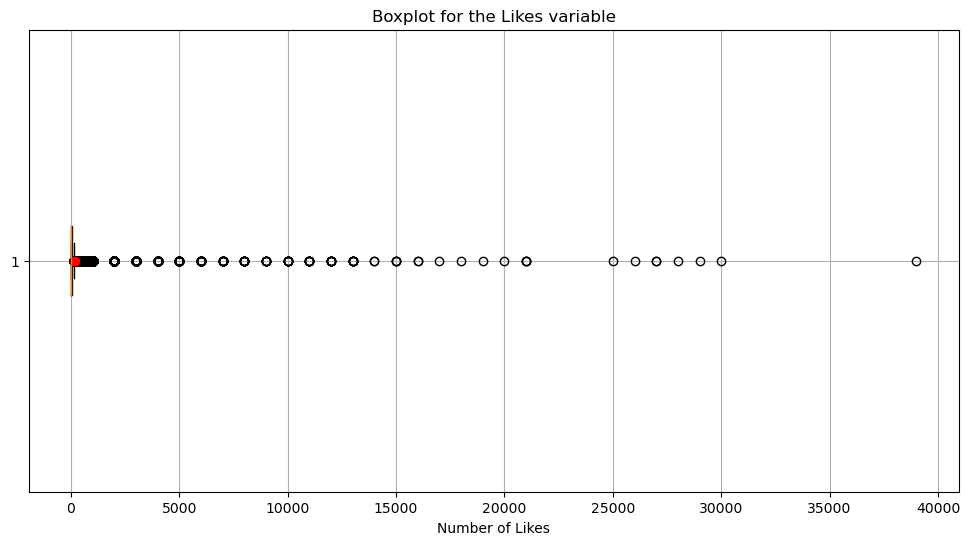

In [43]:
## Generating a plot for the distribution of likes
# Setting the size of the plot
plt.figure(figsize=(12, 6)) 

# Plotting a boxplot
plt.boxplot(df['likes'], vert = False)

# Highlight the mean with a red dot
plt.plot(np.mean(df['likes']), 1, 'ro')

# Setting the titles for the boxplot
plt.title('Boxplot for the Likes variable')
plt.xlabel('Number of Likes')

# Enable grid, and set it to appear behIndependent plot elements
plt.grid(True)

# Plotting the graph
plt.show()

After visualization, we fIndependent that the "likes" distribution is heavily skewed due to an overabundance of extreme values, which in turn was affecting later analysis. Given this, it was decided to calculate the z-score for every data point, and to classify as outlier any observation which had an absolut value above 3.

In [44]:
# Calculate Z-scores of 'variable'
df['z_score'] = (df['likes'] - df['likes'].mean()) / df['likes'].std()

# Filter entries that have a z-score greater than 3 or less than -3
outliers = df[(df['z_score'] > 3) | (df['z_score'] < -3)]

df_no = df[(df['z_score'] < 3) & (df['z_score'] > -3)].reset_index()

In [45]:
# Calculate Z-scores of 'variable'
df_score['z_score'] = (df_score['likes'] - df_score['likes'].mean()) / df_score['likes'].std()

# Filter entries that have a z-score greater than 3 or less than -3
outliers = df_score[(df_score['z_score'] > 3) | (df_score['z_score'] < -3)]

df_score_no = df_score[(df_score['z_score'] < 3) & (df_score['z_score'] > -3)].reset_index()

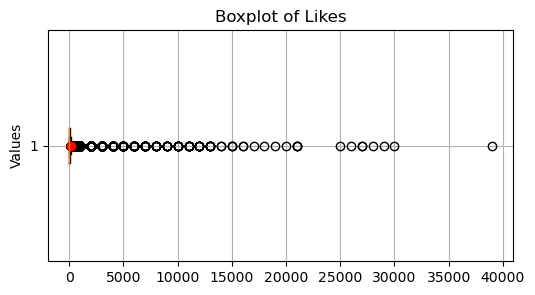

In [46]:
## Generating a plot for the distribution of likes after eliminating extreme values
# Setting the size of the plot
plt.figure(figsize=(6, 3)) 

# Plotting the boxplot
plt.boxplot(df['likes'], vert = False)

# Highlight the mean with a red dot
plt.plot(np.mean(df['likes']), 1, 'ro')

# Setting the titles for the boxplot
plt.title('Boxplot of Likes')
plt.ylabel('Values')

# Enable grid
plt.grid(True)

# Plotting the graph
plt.show()

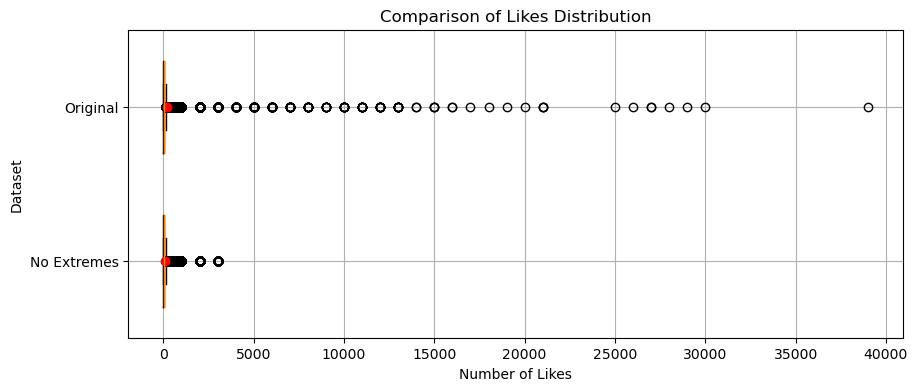

In [47]:
# Set the size of the plot
plt.figure(figsize=(10, 4))

# Data for both plots
likes_original = df['likes']
likes_no_extreme = df_no['likes']

# Create boxplots
plt.boxplot([likes_original, likes_no_extreme], vert=False, positions=[2, 1], widths=0.6)

# Highlight the means
plt.plot(np.mean(likes_original), 2, 'ro')  # Red dot for the original data
plt.plot(np.mean(likes_no_extreme), 1, 'ro')  # Red dot for the filtered data

# Setting the titles and labels
plt.title('Comparison of Likes Distribution')
plt.yticks([2, 1], ['Original', 'No Extremes'])  # Labeling the positions
plt.xlabel('Number of Likes')
plt.ylabel('Dataset')

# Enable grid and set it to appear behIndependent plot elements
plt.grid(True)
plt.gca().set_axisbelow(True)

# Plotting the graph
plt.show()


# Response: Likes

DrOppositioning Karyme Adrana Cotes Martínez as she only has one observation, making it impossible to run a regression on her.

In [48]:
df_score_no[df_score_no["author"] == "Karyme Adrana Cotes Martínez"]

,index,tweet,author,user,gender,party,day,month,likes,retweets,...,n_tweet,avg_score,avg_likes,length,petro,uribe,duque,santos,multi,z_score
212,212,Q por favor y q Gracias ! 😄,Karyme Adrana Cotes Martínez,YelenaCotes,1,Liberal Colombiano,1,9,1.0,0.0,...,1,0.6239,1.0,8,0,0,0,0,0,-0.19451


In [49]:
index = df_score_no[df_score_no["author"] == "Karyme Adrana Cotes Martínez"].index[0]
df_score_no = df_score_no.drop(df.index[index]).reset_index(drop = True)

## Score and Likes, gender

## Most used words by likes

In [50]:
popular = df_no.copy()
popular = popular.sort_values("likes", ascending=False).reset_index()
popular = popular.iloc[-int(len(df_no)*0.1):]
list_popular = popular["tweet"].tolist()

# Split each phrase into words_p and flatten the list
words_p = [word.lower() for phrase in list_popular for word in phrase.split()]
words_p = [word.replace('.', '') for word in words_p]
words_p = [word.replace(',', '') for word in words_p]

In [51]:
filtered_words_p = [word for word in words_p if word not in stopwords]

# Create a frequency distribution
freq_dist_p = FreqDist(filtered_words_p)

# Convert frequency distribution to a DataFrame
popular_df_no = pd.DataFrame(freq_dist_p.items(), columns=['Word', 'Frequency'])
popular_df_no = popular_df_no.sort_values("Frequency", ascending = False)

popular_df_no[:15]

,Word,Frequency
56,@camaracolombia,96
1058,ley,86
129,gobierno,82
847,proyecto,80
295,congreso,79
685,colombia,78
203,paz,69
460,país,68
15,nacional,65
870,debate,52


## Length and Likes, by gender

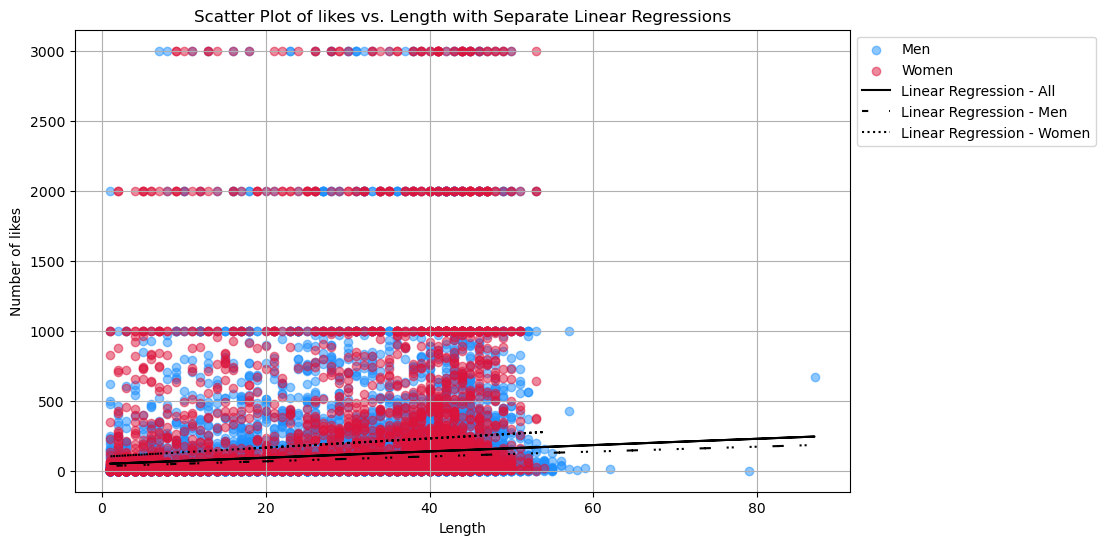

In [52]:
# Data subsets based on gender
Men_data = df_no[df_no['gender'] == 0]
Women_data = df_no[df_no['gender'] == 1]

# Fit the linear regression models
# For the complete data
slope_all, intercept_all, pvalue_all = fit_ols(df_no['length'], df_no['likes'])

# For Men data
slope_Men, intercept_Men, pvalue_Men = fit_ols(Men_data['length'], Men_data['likes'])

# For Women data
slope_Women, intercept_Women, pvalue_Women = fit_ols(Women_data['length'], Women_data['likes'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Men_data['length'], Men_data['likes'], alpha=0.5, color='dodgerblue', label='Men')
plt.scatter(Women_data['length'], Women_data['likes'], alpha=0.5, color='crimson', label='Women')
plt.plot(df_no['length'], slope_all * df_no['length'] + intercept_all, color='black', label='Linear Regression - All')
plt.plot(Men_data['length'], slope_Men * Men_data['length'] + intercept_Men, color='black', linestyle=(0, (3, 10, 1, 10, 1, 10)), label='Linear Regression - Men')
plt.plot(Women_data['length'], slope_Women * Women_data['length'] + intercept_Women, color='black', linestyle="dotted", label='Linear Regression - Women')

# Labeling the axes and title
plt.xlabel('Length')
plt.ylabel('Number of likes')
plt.title('Scatter Plot of likes vs. Length with Separate Linear Regressions')

# Add a grid, limit x-axis
plt.grid(True)

# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

In [53]:
# Print the slope, intercept, and p-value
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)
print("The Coefficient for Women is:", slope_Women, "Intercept:", intercept_Women, "p-value:", pvalue_Women)
print("The Coefficient for Men is:", slope_Men, "Intercept:", intercept_Men, "p-value:", pvalue_Men)

The General Coefficient is: 2.2544850192785626 Intercept: 47.83634622599704 p-value: 3.596711505391757e-40
The Coefficient for Women is: 3.283945848841909 Intercept: 99.32683944065427 p-value: 1.322402741203028e-12
The Coefficient for Men is: 1.7381536446474857 Intercept: 32.584812248852195 p-value: 9.246220572265707e-29


### Calculating

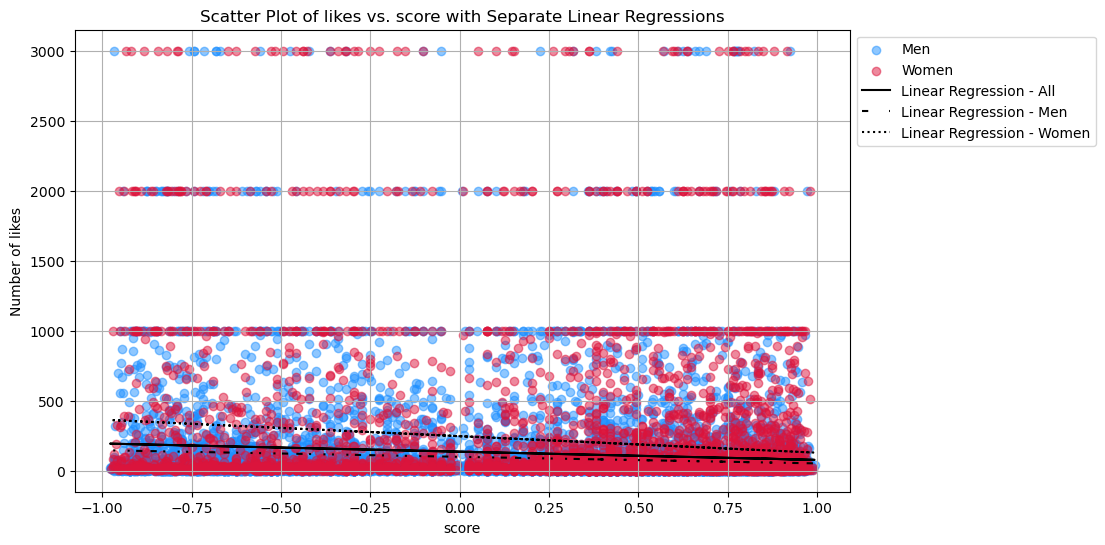

In [54]:
# Data subsets based on gender
Men_data = df_score_no[df_score_no['gender'] == 0]
Women_data = df_score_no[df_score_no['gender'] == 1]

# Fit the linear regression models
# For the complete data
slope_all, intercept_all, pvalue_all = fit_ols(df_score_no['score'], df_score_no['likes'])

# For Men data
slope_Men, intercept_Men, pvalue_Men = fit_ols(Men_data['score'], Men_data['likes'])

# For Women data
slope_Women, intercept_Women, pvalue_Women = fit_ols(Women_data['score'], Women_data['likes'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Men_data['score'], Men_data['likes'], alpha=0.5, color='dodgerblue', label='Men')
plt.scatter(Women_data['score'], Women_data['likes'], alpha=0.5, color='crimson', label='Women')
plt.plot(df_score_no['score'], slope_all * df_score_no['score'] + intercept_all, color='black', label='Linear Regression - All')
plt.plot(Men_data['score'], slope_Men * Men_data['score'] + intercept_Men, color='black', linestyle=(0, (3, 10, 1, 10, 1, 10)), label='Linear Regression - Men')
plt.plot(Women_data['score'], slope_Women * Women_data['score'] + intercept_Women, color='black', linestyle="dotted", label='Linear Regression - Women')

# Labeling the axes and title
plt.xlabel('score')
plt.ylabel('Number of likes')
plt.title('Scatter Plot of likes vs. score with Separate Linear Regressions')

# Add a grid, limit x-axis
plt.grid(True)

# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

In [55]:
# Print the slope, intercept, and p-value
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)
print("The Coefficient for Women is:", slope_Women, "Intercept:", intercept_Women, "p-value:", pvalue_Women)
print("The Coefficient for Men is:", slope_Men, "Intercept:", intercept_Men, "p-value:", pvalue_Men)

The General Coefficient is: -58.607539003270674 Intercept: 135.98086958701248 p-value: 2.4023025348875605e-36
The Coefficient for Women is: -117.97659129068197 Intercept: 246.7298253704729 p-value: 2.627510159350744e-19
The Coefficient for Men is: -47.10498197389224 Intercept: 99.4244079137827 p-value: 8.172642381350688e-29


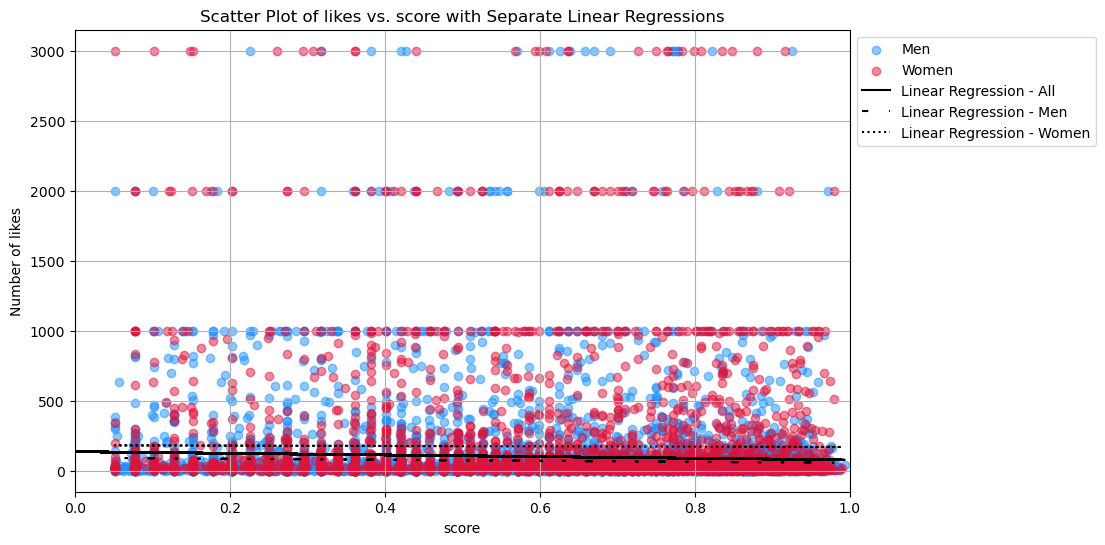

In [56]:
# Data subsets based on gender
Men_data = df_score_no[(df_score_no['gender'] == 0) & (df_score_no['positive'] == 1)]
Women_data = df_score_no[(df_score_no['gender'] == 1) & (df_score_no['positive'] == 1)]

# Fit the linear regression models
# For the complete data
slope_all, intercept_all, pvalue_all = fit_ols(df_score_no['score'], df_score_no['likes'])

# For Men data
slope_Men, intercept_Men, pvalue_Men = fit_ols(Men_data['score'], Men_data['likes'])

# For Women data
slope_Women, intercept_Women, pvalue_Women = fit_ols(Women_data['score'], Women_data['likes'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Men_data['score'], Men_data['likes'], alpha=0.5, color='dodgerblue', label='Men')
plt.scatter(Women_data['score'], Women_data['likes'], alpha=0.5, color='crimson', label='Women')
plt.plot(df_score_no['score'], slope_all * df_score_no['score'] + intercept_all, color='black', label='Linear Regression - All')
plt.plot(Men_data['score'], slope_Men * Men_data['score'] + intercept_Men, color='black', linestyle=(0, (3, 10, 1, 10, 1, 10)), label='Linear Regression - Men')
plt.plot(Women_data['score'], slope_Women * Women_data['score'] + intercept_Women, color='black', linestyle="dotted", label='Linear Regression - Women')

# Labeling the axes and title
plt.xlabel('score')
plt.ylabel('Number of likes')
plt.title('Scatter Plot of likes vs. score with Separate Linear Regressions')

# Add a grid, limit x-axis
plt.grid(True)
plt.xlim(0, 1)

# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

In [57]:
# Print the slope, intercept, and p-value
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)
print("The Coefficient for Women is:", slope_Women, "Intercept:", intercept_Women, "p-value:", pvalue_Women)
print("The Coefficient for Men is:", slope_Men, "Intercept:", intercept_Men, "p-value:", pvalue_Men)

The General Coefficient is: -58.607539003270674 Intercept: 135.98086958701248 p-value: 2.4023025348875605e-36
The Coefficient for Women is: -12.229560106294624 Intercept: 181.63934179783436 p-value: 0.6777828601557596
The Coefficient for Men is: -36.24604046389945 Intercept: 92.63236043384148 p-value: 0.0004850844366158213


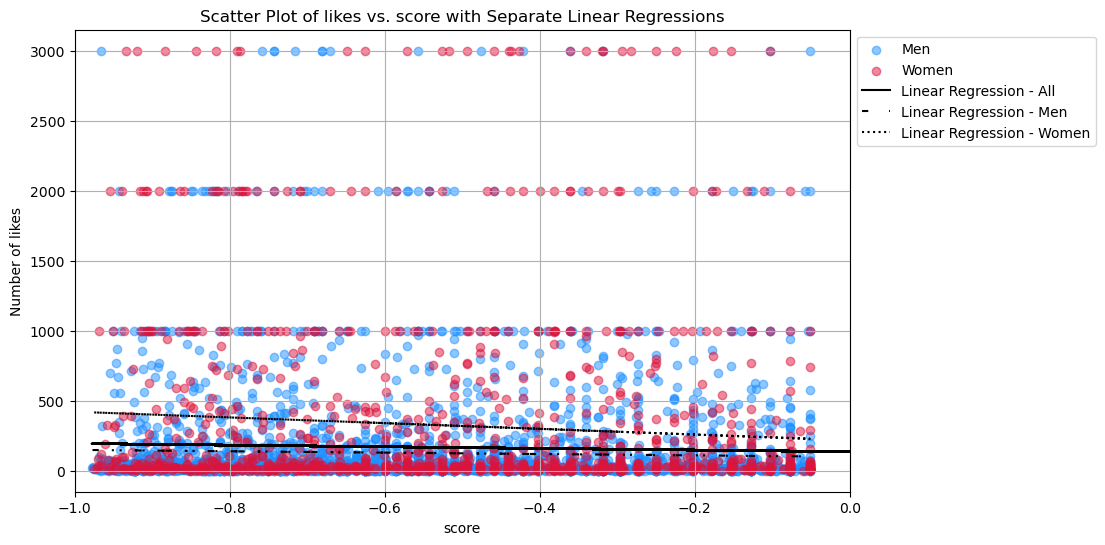

In [58]:
# Data subsets based on gender
Men_data = df_score_no[(df_score_no['gender'] == 0) & (df_score_no['negative'] == 1)]
Women_data = df_score_no[(df_score_no['gender'] == 1) & (df_score_no['negative'] == 1)]

## Fit the linear regression models
# For the complete data
slope_all, intercept_all, pvalue_all = fit_ols(df_score_no['score'], df_score_no['likes'])

# For Men data
slope_Men, intercept_Men, pvalue_Men = fit_ols(Men_data['score'], Men_data['likes'])

# For Women data
slope_Women, intercept_Women, pvalue_Women = fit_ols(Women_data['score'], Women_data['likes'])

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Men_data['score'], Men_data['likes'], alpha=0.5, color='dodgerblue', label='Men')
plt.scatter(Women_data['score'], Women_data['likes'], alpha=0.5, color='crimson', label='Women')
plt.plot(df_score_no['score'], slope_all * df_score_no['score'] + intercept_all, color='black', label='Linear Regression - All')
plt.plot(Men_data['score'], slope_Men * Men_data['score'] + intercept_Men, color='black', linestyle=(0, (3, 10, 1, 10, 1, 10)), label='Linear Regression - Men')
plt.plot(Women_data['score'], slope_Women * Women_data['score'] + intercept_Women, color='black', linestyle="dotted", label='Linear Regression - Women')

# Labeling the axes and title
plt.xlabel('score')
plt.ylabel('Number of likes')
plt.title('Scatter Plot of likes vs. score with Separate Linear Regressions')

# Add a grid, limit x-axis
plt.grid(True)
plt.xlim(-1,0)
# Adjust the legend to be outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

# Show the plot
plt.show()

In [59]:
# Print the slope, intercept, and p-value
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)
print("The Coefficient for Women is:", slope_Women, "Intercept:", intercept_Women, "p-value:", pvalue_Women)
print("The Coefficient for Men is:", slope_Men, "Intercept:", intercept_Men, "p-value:", pvalue_Men)

The General Coefficient is: -58.607539003270674 Intercept: 135.98086958701248 p-value: 2.4023025348875605e-36
The Coefficient for Women is: -203.74373152490136 Intercept: 217.67346880452237 p-value: 0.0031668902309978145
The Coefficient for Men is: -49.20712665263397 Intercept: 99.70217351591624 p-value: 0.016658967086415337


## Likes and Length, Association

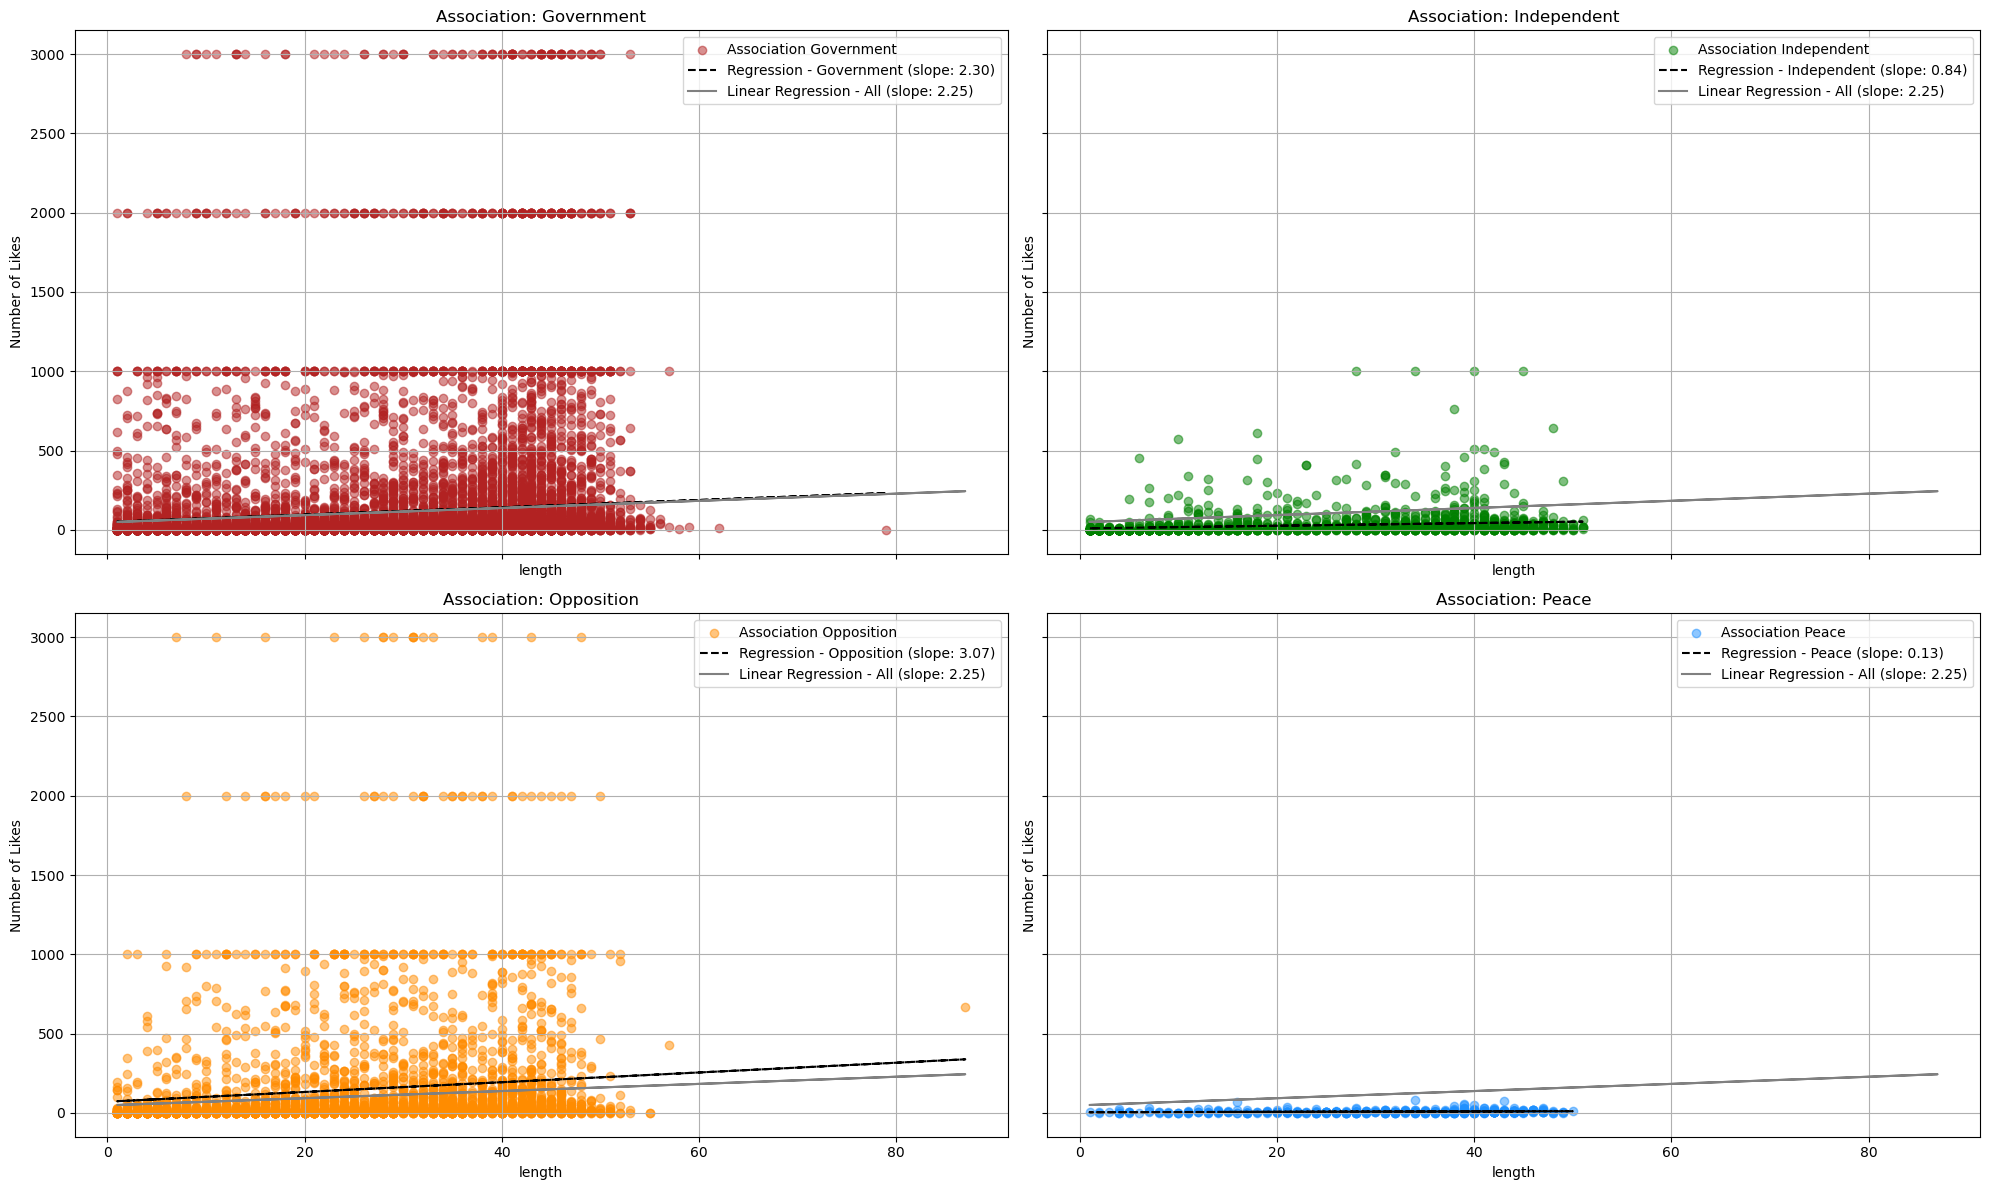

In [60]:
# Data subsets based on associations
association_groups = df_no.groupby('association')

# Colors for each association
colors = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent": "green"}

# Fit the linear regression model for the overall data
slope_all, intercept_all, pvalue_all = fit_ols(df_no['length'], df_no['likes'])
regression_line_all = intercept_all + slope_all * df_no['length']

# Prepare to store statistics for each association
association_stats = {}

# Determine the number of associations for layout
num_associations = len(association_groups)
cols = 2  # Adjust this based on your preference
rows = (num_associations + cols - 1) // cols  # Ensures enough rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 6 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make iteration easier

for idx, (association, data) in enumerate(association_groups):
    # Fit the linear regression for each association
    slope, intercept, pvalue = fit_ols(data['length'], data['likes'])
    association_stats[association] = (slope, intercept, pvalue)
    regression_line = intercept + slope * data['length']
    
    ax = axes[idx]
    ax.scatter(data['length'], data['likes'], alpha=0.5, color=colors[association], label=f'Association {association}')
    ax.plot(data['length'], regression_line, color='black', linestyle='--', label=f'Regression - {association} (slope: {slope:.2f})')
    ax.plot(df_no['length'], regression_line_all, color='gray', label='Linear Regression - All (slope: {:.2f})'.format(slope_all))
    ax.set_title(f'Association: {association}')
    ax.set_xlabel('length')
    ax.set_ylabel('Number of Likes')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [61]:
# Print the slope, intercept, and p-value for the overall data
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)

# Print the slope, intercept, and p-value for each association
for association, stats in association_stats.items():
    print(f"The Coefficient for {association.capitalize()} is: Slope: {stats[0]:.2f}, Intercept: {stats[1]:.2f}, p-value: {stats[2]:.4f}")

The General Coefficient is: 2.2544850192785626 Intercept: 47.83634622599704 p-value: 3.596711505391757e-40
The Coefficient for Government is: Slope: 2.30, Intercept: 50.11, p-value: 0.0000
The Coefficient for Independent is: Slope: 0.84, Intercept: 9.05, p-value: 0.0000
The Coefficient for Opposition is: Slope: 3.07, Intercept: 70.79, p-value: 0.0000
The Coefficient for Peace is: Slope: 0.13, Intercept: 4.27, p-value: 0.0005


## Likes and Score, Association

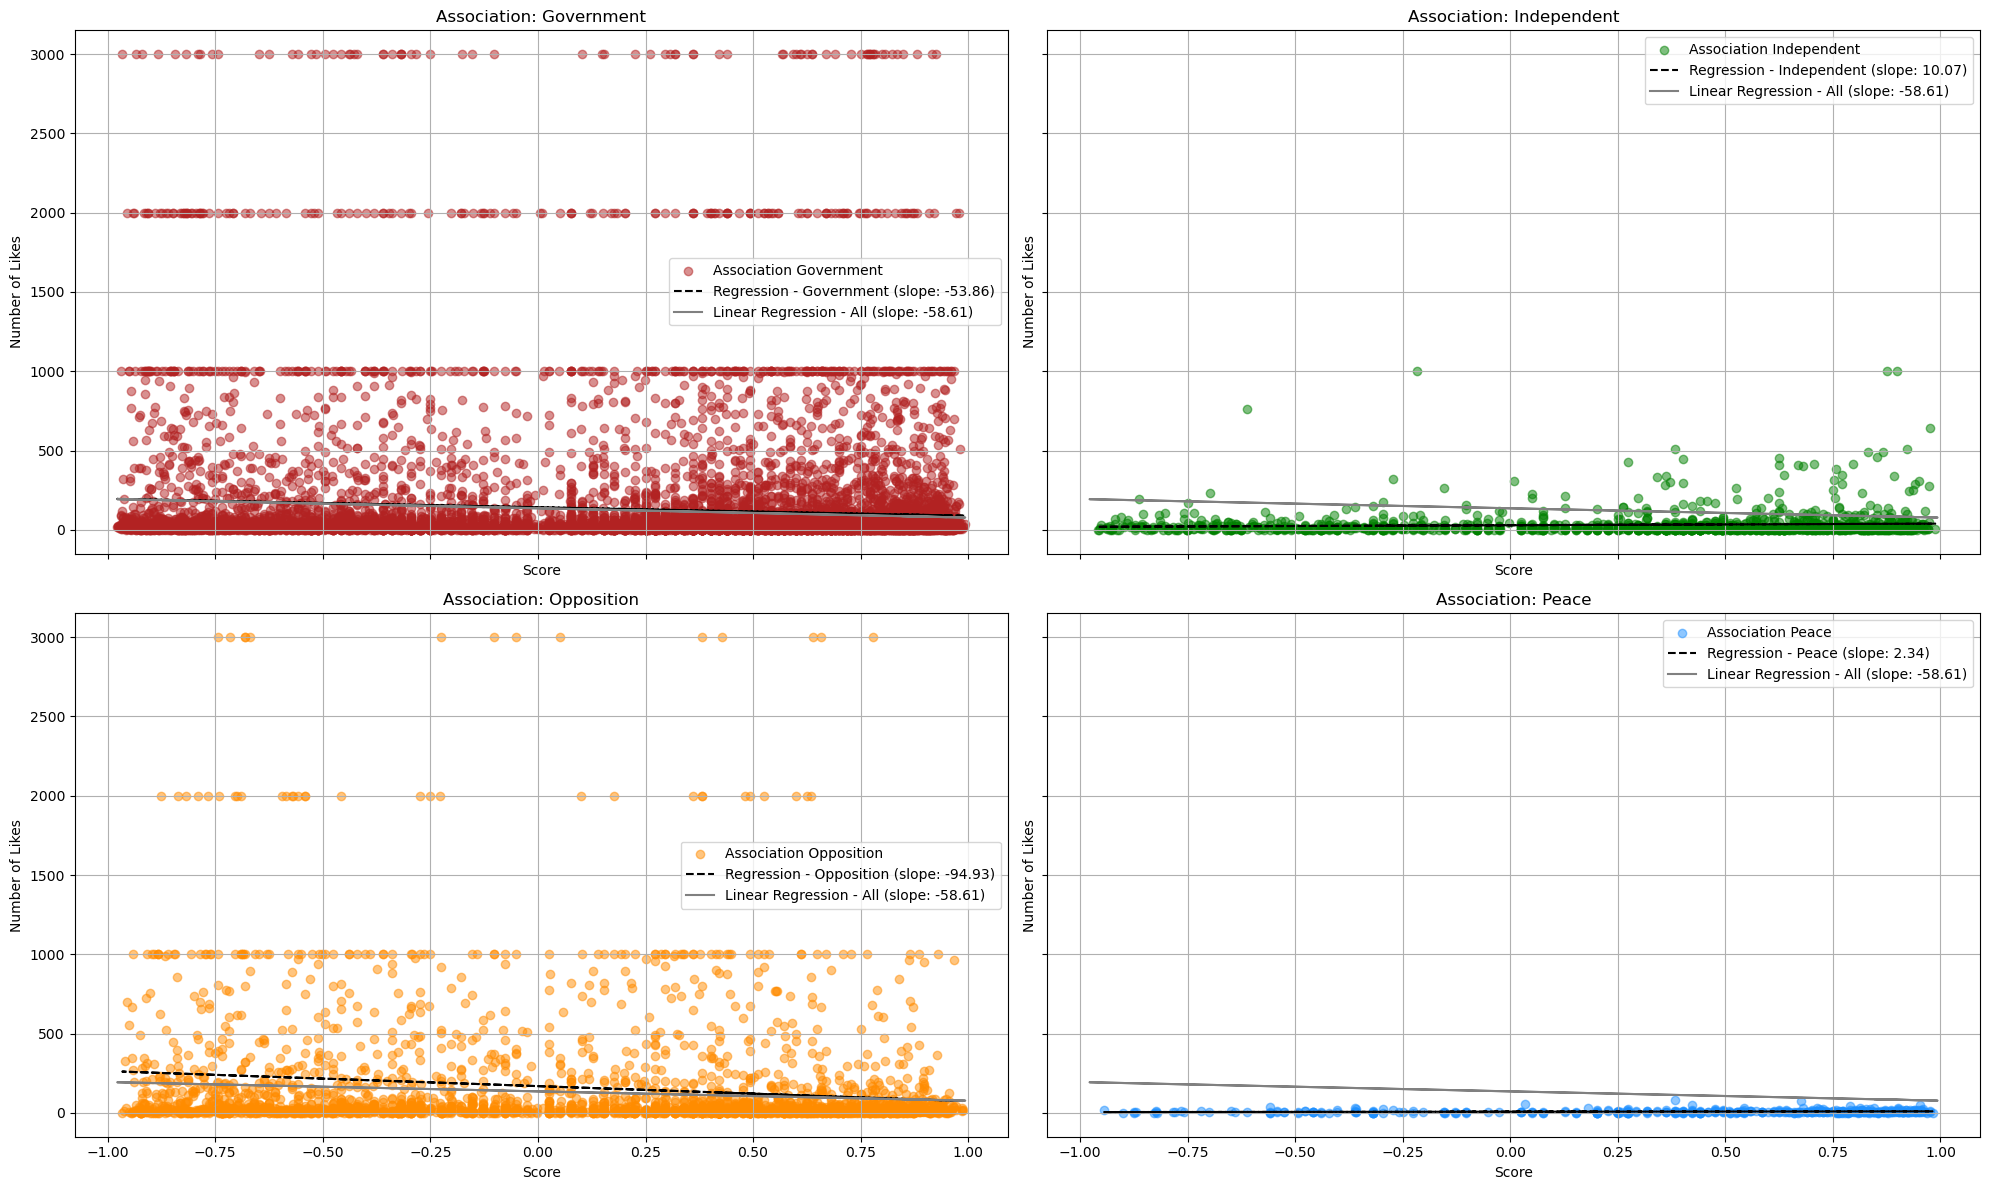

In [62]:
# Data subsets based on associations
association_groups = df_score_no.groupby('association')

# Colors for each association
colors = {'Opposition': 'darkorange', 'Government': 'firebrick', "Peace": "dodgerblue", "Independent": "green"}

# Fit the linear regression model for the overall data
slope_all, intercept_all, pvalue_all = fit_ols(df_score_no['score'], df_score_no['likes'])
regression_line_all = intercept_all + slope_all * df_score_no['score']

# Prepare to store statistics for each association
association_stats = {}

# Determine the number of associations for layout
num_associations = len(association_groups)
cols = 2  # Adjust this based on your preference
rows = (num_associations + cols - 1) // cols  # Ensures enough rows

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(10 * cols, 6 * rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make iteration easier

for idx, (association, data) in enumerate(association_groups):
    # Fit the linear regression for each association
    slope, intercept, pvalue = fit_ols(data['score'], data['likes'])
    association_stats[association] = (slope, intercept, pvalue)
    regression_line = intercept + slope * data['score']
    
    ax = axes[idx]
    ax.scatter(data['score'], data['likes'], alpha=0.5, color=colors[association], label=f'Association {association}')
    ax.plot(data['score'], regression_line, color='black', linestyle='--', label=f'Regression - {association} (slope: {slope:.2f})')
    ax.plot(df_score_no['score'], regression_line_all, color='gray', label='Linear Regression - All (slope: {:.2f})'.format(slope_all))
    ax.set_title(f'Association: {association}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Number of Likes')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [63]:
# Print the slope, intercept, and p-value for the overall data
print("The General Coefficient is:", slope_all, "Intercept:", intercept_all, "p-value:", pvalue_all)

# Print the slope, intercept, and p-value for each association
for association, stats in association_stats.items():
    print(f"The Coefficient for {association.capitalize()} is: Slope: {stats[0]:.2f}, Intercept: {stats[1]:.2f}, p-value: {stats[2]:.4f}")

The General Coefficient is: -58.607539003270674 Intercept: 135.98086958701248 p-value: 2.4023025348875605e-36
The Coefficient for Government is: Slope: -53.86, Intercept: 142.59, p-value: 0.0000
The Coefficient for Independent is: Slope: 10.07, Intercept: 29.25, p-value: 0.0107
The Coefficient for Opposition is: Slope: -94.93, Intercept: 169.01, p-value: 0.0000
The Coefficient for Peace is: Slope: 2.34, Intercept: 7.84, p-value: 0.0138
